# Multi-Modal Multi-Agent AI Orchestrator (Amazon Bedrock & Nova)


This project showcases a complex multi-modal, multi-agent workflow that leverages Amazon Bedrock features and the Nova foundation model to handle user queries with advanced reasoning, retrieval, and generative capabilities. It integrates multiple specialized agents (for routing, supervision, report writing, audio search, image search, etc.) that collaborate to answer questions by analyzing text, audio, and image data. The system dynamically plans workflows, uses memory for context, and can incorporate external information (web search, financial APIs, etc.) to produce a comprehensive response. 

<img src="./images/agentic_orchestration.png" width="950" />

Key components of the architecture include:

* Router Agent: Entry point that interprets the user query, accesses Agent Memory for relevant context, and decides on a plan (which agents/tools to invoke). It performs adaptive routing of requests based on query type and context (e.g. routing an audio-related question to the audio agent, invoking a web search for a timely data question, etc.). 

*  Supervisor Agent: Oversees the execution of the plan. It manages multi-agent collaboration, spawning or calling specialized agents as needed and sequencing their actions. The Supervisor collects results from each agent and handles the logic to merge these into a cohesive answer. 

*  Audio Search Agent: Specialized agent for audio content. It queries an Audio Knowledge Base to find information relevant to the user’s question from audio transcripts or audio files. Audio files (e.g. call recordings, podcasts) are ingested from an S3 bucket and processed through Bedrock Data Automation to generate transcripts and embeddings, which is indexed by Bedrock Knowledge Base. This is part of a Retrieval-Augmented Generation (RAG) approach, ensuring audio-derived facts can be included accurately.

*  Image Search Agent: Specialized agent for image content. It works similarly to the audio agent but with an Image Knowledge Base. Images (e.g. diagrams, figures) are stored in S3 and analyzed by Bedrock Data Automation, which extracts metadata, tags, or captions (and possibly generates embeddings) from the images. 

*  Report Writer Agent: The Report Writer’s role is to synthesize a comprehensive report or answer for the user. The Report Writer Agent also invokes image generation if the final report would benefit from a visual (for example, creating a chart or diagram to illustrate a trend). Amazon Nova’s model family includes Nova Canvas for image generation , which is leveraged here as a Bedrock-provided tool. 

Throughout this workflow, the LangGraph orchestration framework underpins the interactions.

# Advanced Features Summary

*  Nova Foundation Model 

*  Bedrock Data Automation for Multimodal RAG

*  Multi-Agent Orchestration

*  Dynamic Prompt Rewriting & Adaptive Routing

*  Retrieval-Augmented Generation (RAG)

*  Hallucination Grading

*  External Knowledge and Tools

*  Memory and Context


In [2]:
!pip install -q --no-cache-dir wheel setuptools==67.8.0 pip --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sip 6.10.0 requires setuptools>=69.5, but you have setuptools 67.8.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.3.2 which is incompatible.
zope-event 5.1.1 requires setuptools>=75.8.2, but you have setuptools 67.8.0 which is incompatible.


In [3]:
!pip install --upgrade setuptools>=69.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.3.2 which is incompatible.


In [4]:
!pip install -q --no-cache-dir -r ./requirements.txt

In [5]:
!pip install -q --no-cache-dir ta

### Restart the kernel

In [ ]:
import os
os._exit(00)

## 1. Setting Up API keys or tokens 

To access various services, such as Amazon Bedrock for Large Language Models (LLMs) and embedding models, Tavily web search engine, and optional Langchain, you will need to set up and obtain the necessary API keys or tokens. These API keys and tokens serve as authentication credentials that allow your application to securely connect and interact with the respective services.

In [6]:
import sys
import os
import boto3
import json
import requests
from datetime import date, datetime
from pprint import pprint
from botocore.client import Config
from botocore.exceptions import ClientError
import nest_asyncio
import pandas as pd
import random
import base64
import io
import matplotlib.pyplot as plt

from typing import List, TypedDict, Any, Tuple
from typing import Union, Dict, Set, Annotated, Optional
from pydantic import BaseModel, Field

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent, tools_condition, ToolNode

from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.callbacks.tracers import LangChainTracer
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.base import BaseCallbackHandler
from langchain.chains import RetrievalQA

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AnyMessage
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod #, NodeColors

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


from langchain_aws.retrievers import AmazonKnowledgeBasesRetriever
from langchain_aws import BedrockEmbeddings

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import Image, Markdown, display, HTML
from PIL import Image

from chromadb import Documents, EmbeddingFunction, Embeddings
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price

import operator
import re

from utils.knowledge_base_operators import extract_audio_path_and_timestamps_agent_response, extract_audio_path_and_timestamps
from utils.knowledge_base_operators import play_audio_segments_from_s3

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Pre-requisite: 

### Please note, you have to create Bedrock knowledge base for audio files amd image files for this notebook. Please run notebooks 1-3 in folder <mark> audio-video-rag. 

In [7]:

nest_asyncio.apply()   

aws_region = "us-east-1" # choose your region you operate in

#os.environ['FINANCIAL_MODEL_PREP_KEY'] = FINANCIAL_MODELING_PREP_API_KEY = 
os.environ['AUDIO_KB_ID'] = AUDIO_KB_ID = '3G7445GLRN'
os.environ['IMAGE_KB_ID'] = IMAGE_KB_ID = 'KEQALZYHI0'

# Temp image file
temp_gen_image = "./delme.png"
markdown_filename = "./blogpost.md"


#from blog_writer import *
from utils.bedrock import *


## 2. Creating a Bedrock Runtime Client
We'll create a Bedrock runtime client to connect to the Amazon Bedrock service. Bedrock, a fully managed service by AWS, allows developers to build and deploy generative AI models like large language models (LLMs). This client will enable us to leverage pre-trained LLMs from Amazon, such as the powerful LLaMA3 model from Meta.

Connecting to Bedrock is crucial for building our scalable and secure RAG agent, as it provides the necessary language model for generation capabilities. With the Bedrock runtime client in place, we can integrate LLaMA3 into our workflow and use its advanced natural language processing capabilities to generate accurate responses.

In [8]:
### Select models
options = [ "us.amazon.nova-lite-v1:0", "us.amazon.nova-pro-v1:0"]
# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=options,
    value=options[1],
    description='Choose an option:',
    disabled=False,
)

# Display the dropdown widget
display(dropdown)

Dropdown(description='Choose an option:', index=1, options=('us.amazon.nova-lite-v1:0', 'us.amazon.nova-pro-v1…

### Please note, you can use either Nova pro or Nova lite for the agent workflow. This workflow also needs anthropic Clude 3.5 sonnet model and Mistral large to grade hallucination and content relevency of Nova responses. Please ensure you also enabled these two models from Bedrock.  

In [9]:
model_id = dropdown.value

model_id_c35 = "anthropic.claude-3-5-sonnet-20240620-v1:0" # Due to model access restriction #'anthropic.claude-3-5-sonnet-20240620-v1:0' 
model_id_mistral_large = 'mistral.mistral-large-2402-v1:0'
model_id_novapro = "us.amazon.nova-pro-v1:0"
model_id_novalite = "us.amazon.nova-lite-v1:0"
# Choose multiple models for different purpose to deversify and avoid potential bias 
llm = get_llm(model_id)
llm_claude35 = get_llm(model_id_c35)
llm_mistral = get_llm(model_id_mistral_large)
llm_novapro = get_llm(model_id_novapro)
llm_novalite = get_llm(model_id_novalite)

In [10]:
config = Config(
        retries = dict(
            max_attempts = 10,
            total_max_attempts = 25,
        )
    )

bedrock_client = boto3.client("bedrock-runtime", config=config) 

In [11]:
def convert_to_dbl_qt(input: str) -> str:
  return input.replace("'", '"') 

## 3. Create agentic services with multi-agent capability

Creating agentic services with multi-agent capability using Amazon Bedrock, Converse API, and LangChain can be a powerful approach to building intelligent and collaborative systems. Amazon Bedrock provides a foundation for developing large language models (LLMs) and integrating them into applications, while the Converse API enables seamless communication between these models and external services. LangChain, on the other hand, offers a framework for building complex, multi-agent systems that can leverage the capabilities of various LLMs and other AI components. By combining these tools, developers can create agentic services that can engage in dynamic, context-aware interactions, share knowledge, and coordinate their efforts to tackle complex tasks. This approach can be particularly useful in scenarios where a diverse set of specialized agents need to collaborate, such as in enterprise automation, customer service, or research and development.

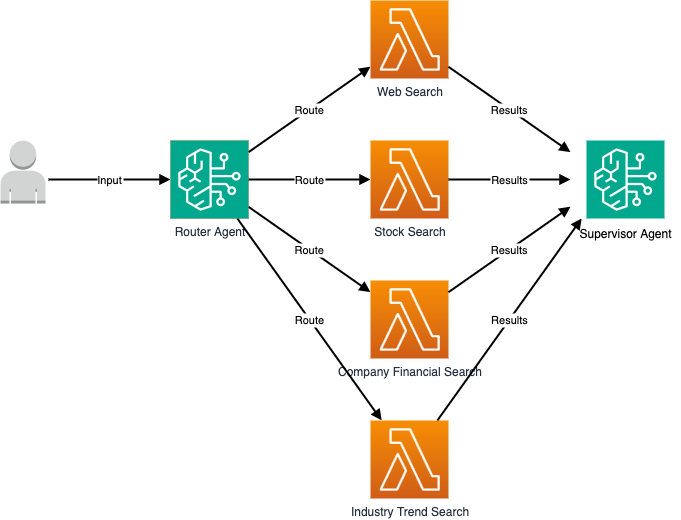

In [40]:
from PIL import Image
from IPython.display import display

img = Image.open('Multi-Agent System.png')
display(img)

### Create four tools for stock and TA analysis

In [12]:

@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches current and historical stock price data for a given ticker."""
    try:
        import datetime as dt
        import yfinance as yf
        
        # Get stock data for the last 3 months
        stock = yf.Ticker(ticker)
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(days=90),
            end=dt.datetime.now(),
            interval='1d'
        )
        
        if data.empty:
            return f"No data found for ticker {ticker}"

        try:
            current_price = float(data['Close'].iloc[-1])
            previous_close = float(data['Close'].iloc[-2])
            current_volume = float(data['Volume'].iloc[-1])
            
            price_change = current_price - previous_close
            price_change_percent = (price_change / previous_close) * 100
            high_90d = float(data['High'].max())
            low_90d = float(data['Low'].min())
            avg_volume = float(data['Volume'].mean())

            return {
                "stock": ticker,
                "current_price": round(current_price, 2),
                "previous_close": round(previous_close, 2),
                "price_change": round(price_change, 2),
                "price_change_percent": round(price_change_percent, 2),
                "volume": int(current_volume),
                "high_90d": round(high_90d, 2),
                "low_90d": round(low_90d, 2),
                "average_volume": int(avg_volume),
                "date": dt.datetime.now().strftime("%Y-%m-%d")
            }

        except IndexError:
            return f"Insufficient data for ticker {ticker}"

    except Exception as e:
        return f"Error fetching price data: {str(e)}"


In [13]:
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'pe_ratio': info.get('forwardPE'),
            'price_to_book': info.get('priceToBook'),
            'debt_to_equity': info.get('debtToEquity'),
            'profit_margins': info.get('profitMargins'),
            'previous_close': stock.info['previousClose']
        }
    except Exception as e:
        return f"Error fetching ratios: {str(e)}"

In [17]:
# search tools
search = DuckDuckGoSearchRun()

In [16]:
!pip install -q --no-cache-dir -U ddgs

In [18]:
class CompanyFinancials(BaseModel):
    symbol:str =  Field(description="The symbol of the company")
    companyName:str =  Field(description="The name of the company")
    marketCap:float = Field(alias="mktCap", description="The market capitalization of the company")
    industry:str =  Field(description="The industry of the company")
    sector:str =  Field(description="The sector of the company")
    description:str = Field(description="The description of the company")
    website:str =  Field(description="The website of the company")
    beta:float = Field(description="The beta of the company")
    price:float = Field(description="The price of the company")
@tool
def get_company_financials(symbol) -> Tuple[Any, CompanyFinancials]:
    """
    Fetch basic financial information for the given company symbol such as the industry, the sector, the name of the company, and the market capitalization.
    """
    try:
      url = f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={FINANCIAL_MODELING_PREP_API_KEY}"
      response = requests.get(url)
      data = response.json()
      financials = CompanyFinancials(**data[0])
      return financials
    except (IndexError, KeyError):
        return {"error": f"Could not fetch financials for symbol: {symbol}"}


In [19]:
# Update the tools list to include the stock price function
tools = [search, get_stock_prices, get_financial_metrics, get_company_financials]

llm_with_tools = llm_claude35.bind_tools(tools)


In [20]:
FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company performance based on stock prices, technical indicators, and financial metrics. Your task is to provide a comprehensive summary of the fundamental analysis for a given company.

You have access to the following tools:
1. **search**: to find information relevant with the question to get company symbols so that you can use tools more effectively
2. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like 90 days high and low.
3. **get_financial_metrics**: Retrieves key financial metrics, such as revenue, earnings per share (EPS), price-to-earnings ratio (P/E), and debt-to-equity ratio.
4. **get_company_financials**: Retrieves key company information, such as description of the company, industry, etc.

### Your Task:
1. **Search**: Use the search tool to search relevant information to finish necessary task on stock analysis.
2. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
3. **Provide Summary**: Write a concise, well-structured summary that highlights:
    - Recent stock price movements, trends and potential resistance.
    - Key insights from technical indicators (e.g., whether the stock is overbought or oversold).
    - Financial health and performance based on financial metrics.

### Constraints:
- Avoid speculative language; focus on observable data and trends.
- If any tool fails to provide data, clearly state that in your summary.

### Output Format:
Respond in the following format:
"stock": "<Stock Symbol>",
"price_analysis": "<Detailed analysis of stock price trends>",
"technical_analysis": "<Detailed time series Analysis from ALL technical indicators>",
"financial_analysis": "<Detailed analysis from financial metrics>",
"final Summary": "<Full Conclusion based on the above analyses>"
"Asked Question Answer": "<Answer based on the details and analysis above>"

Ensure that your response is objective, concise, and actionable."""

def reasoner(state):
    """
    Fundamental analysis reasoner function
    """
    query = state["question"]
    messages = state["messages"]
    result = []
    
    # System message indicating the assistant's capabilities
    sys_msg = SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT)
    message = HumanMessage(content=query)
    messages.append(message)
    
    # Invoke the LLM with the messages
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    
    # Print the response steps
    print("\n=== Reasoner Analysis Steps ===")
    for idx, m in enumerate(result, 1):
        print(f"\nStep {idx}:")
        m.pretty_print()

    # When analysis is complete
    if result and "complete analysis" in result[-1].content.lower():
        return {
            "messages": result,
            "__end__": True  # Signal to end the conversation
        }
        
    # If analysis is not complete
    return {
        "messages": result
    }


### Define Agentic State for LangGraph to maintain parameter propagation

In [21]:
class MultiAgentState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        symbol: The symbol of the company.
        income_statement: The income statement of the company.
        company_financials: The company financials of the company.
        stock_price: The stock price of the company.
    """
    question: str
    question_type: str
    answer: str
    feedback: str
    request: str
    chat_chain: Any
    final_answer: str
    error: str
    messages: Annotated[list[AnyMessage], operator.add]
    # Added audio-related states
    audio_info: dict  # Will contain s3_info and timestamps
    audio_processed: bool
    has_audio: bool
    has_images: bool
    image_citations: Any
    raw_response: Any  # For storing KB response

# Initialize with empty/default values
initial_state = MultiAgentState(
    question="",
    question_type="",
    answer="",
    feedback="",
    request="",
    chat_chain=None,
    final_answer="",
    error="",
    messages = [],
    # Added audio-related initializations
    audio_info={
        's3_info': None,
        'timestamps': None
    },
    audio_processed=False,
    has_audio=False,
    has_images=False,
    image_citations=[],
    raw_response=None
)

memory = MemorySaver()
embedding_model_id = "amazon.titan-embed-text-v2:0"


In [22]:
#####
# Router agent
#####
question_category_prompt = '''You are a senior specialist of Financial Analytical Support. Your task is to classify the incoming questions. 
Depending on your answer, question will be routed to the right team, so your task is crucial for our team. 
There are 5 possible question types: 
- **audioearningcall** - Answer questions related to pre-indexed Amazon earning call related topics stored in the vactorestore.
- **Image_Search**- Answer questions related with image, figure, or diagram search about company's financial perforamance
- **company_financial**- Answer questions based on Company Financial information, such as stock information, income statement, stock volatility, etc.
- **chat**- Answer questions for LLM or a few LLMs.
- **financial_report**- Answer questions, writing a financial report. use retrived information to create the report.
If the intent isn't clear or doesn't match any specific category, use **chat**.
Return in the output only one word (audioearningcall, Image_Search, CompanyFinancial, chat, financial_report).

'''

def router_node(state: MultiAgentState):
    print('Router node started execution')
    messages = [
        SystemMessage(content=question_category_prompt), 
        HumanMessage(content=state['question'])
    ]
    response = llm.invoke(messages)
    print('Question type: %s' % response.content)
    return {"question_type": response.content}


In [23]:
#######
# AUDIO RAG
#######
def rag_node(state: MultiAgentState):
    """
    RAG node function using Amazon Knowledge Bases with audio segment playback
    Args:
        state: MultiAgentState containing the question
    Returns:
        dict: Contains the answer, response object, and audio processing results
    """
    try:
        # Initialize the Knowledge Base retriever
        retriever = AmazonKnowledgeBasesRetriever(
            knowledge_base_id=AUDIO_KB_ID,
            retrieval_config={
                "vectorSearchConfiguration": {
                    "numberOfResults": 3
                }
            }
        )

        # Create the QA chain
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            retriever=retriever,
            return_source_documents=True
        )

        # Get the question from state
        question = state['question']

        # Get response from the chain
        response = qa_chain(question)
        
        # Extract the generated answer
        generation = response['result']

        # Extract audio information and timestamps from the response
        audio_s3_info, timestamps = extract_audio_path_and_timestamps(response)
            
        # Store audio information in state for later use
        state['audio_info'] = {
            's3_info': audio_s3_info,
            'timestamps': timestamps
        }
        state['audio_processed'] = True
        state['has_audio'] = bool(audio_s3_info and timestamps)
        state['raw_response'] = response
        
        # Return enhanced response with all information
        return {
            'answer': generation,
            'raw_response': response,  # Include full response for downstream processing
        }

    except Exception as e:
        print(f"Error in RAG node: {e}")
        return {
            'answer': f"Error occurred while processing the question: {str(e)}",
            'raw_response': None,
            'audio_info': None
        }
 

In [24]:
#######
# IMAGE RAG
#######
def rag_node_image(state: MultiAgentState):
    """
    RAG node function using Amazon Knowledge Bases for image retrieval
    Args:
        state: MultiAgentState containing the question
    Returns:
        dict: Contains the answer, response object, and image citations
    """
    try:
        # Initialize the Knowledge Base retriever
        retriever = AmazonKnowledgeBasesRetriever(
            knowledge_base_id=IMAGE_KB_ID,
            retrieval_config={
                "vectorSearchConfiguration": {
                    "numberOfResults": 3
                }
            }
        )

        # Get the question from state
        question = state['question']
        
        try:
            # Get documents using invoke
            retrieved_docs = retriever.invoke(question)
            
            if not retrieved_docs:
                raise ValueError("No documents retrieved")
                
            # Process retrieved documents
            if isinstance(retrieved_docs, list):
                # Extract content and citations from retrieved documents
                citations = []
                content = []
                
                for doc in retrieved_docs:
                    if hasattr(doc, 'metadata') and 'citations' in doc.metadata:
                        citations.extend(doc.metadata['citations'])
                    if hasattr(doc, 'page_content'):
                        content.append(doc.page_content)
                
                response = {
                    'result': '\n'.join(content) if content else '',
                    'citations': citations,
                    'source_documents': retrieved_docs
                }
            else:
                response = retrieved_docs

        except Exception as chain_error:
            print(f"Retrieval error: {chain_error}")
            return {
                'answer': f"Error retrieving documents: {str(chain_error)}",
                'raw_response': None
            }

        # Store response in state
        state['raw_response'] = response
        
        # Extract and store image citations
        citations = response.get('citations', [])
        if citations:
            state['has_images'] = True
            state['image_citations'] = citations
        else:
            state['has_images'] = False
            state['image_citations'] = None

        # Update state instead of returning new dict
        state['answer'] = response.get('result', '')
        state['raw_response'] = response
        
        return state  # Return the entire state object

    except Exception as e:
        print(f"Error in RAG node: {e}")
        print(f"Error type: {type(e)}")
        print(f"Error details: {str(e)}")
        
        # Update state with error information
        state['answer'] = f"Error occurred while processing the question: {str(e)}"
        state['raw_response'] = None
        return state  # Return the entire state object

In [25]:

#####
# LLM node
####
def llm_node(state: MultiAgentState):
    model_ids = [model_id_mistral_large , model_id_c35]
    max_tokens = 2048
    temperature = 0.01
    top_p = 0.95

    conversation = [
        {
            "role": "user",
            #"system": "You are a domain expert who can understand the intent of user query and answer question truthful and professionally. Please, don't provide any unchecked information and just tell that you don't know if you don't have enough info.",
            "content": [{"text": state['question']}],
        }
    ]
    try:
        # Send the message to the model, using a basic inference configuration.
        responses = []
        for model_id in model_ids:
            response = bedrock_client.converse(
                modelId=model_id,
                messages=conversation,
                inferenceConfig={"maxTokens": max_tokens, "temperature": temperature, "topP": top_p},
            )
        
            # Extract and print the response text.
            responses.append( response["output"]["message"]["content"][0]["text"])

        ###
        # Combine the answers to form a unified one
        ###
        c3_template = """Your are a domain expert and your goal is to Merge and eliminate redundant elements from {{responses}} that captures the essence of all input while adhering to the following the {{instruction}}.
        <instructions> 
            <step>Aggregate relevant information from the provided context.</step> 
            <step>Eliminate redundancies to ensure a concise response.</step> 
            <step>Maintain fidelity to the original content.</step> 
            <step>Add additional relevent info to the question or removing iirelevant information.</step>
        </instructions> 
        <responses>
            {responses}
        </responses>
        """
        
        messages = [
            SystemMessage(content=c3_template), 
            HumanMessage(content=state['question'])
        ]

        return {'answer': llm.invoke(messages)}
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")  

In [26]:
#####
# Image generation node
####
def t2i_node(state:MultiAgentState):
    
    client = boto3.client("bedrock-runtime", region_name="us-east-1")
    model_id = "amazon.nova-canvas-v1:0"
    
    prompt = f"Generate a high resolution, photo realistic picture of {state['question']} with vivid color and attending to details."
        
    accept = "application/json"
    content_type = "application/json"
    
    # Format the request payload
    request_payload = json.dumps({
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            
        }
    })
        
    try:
      
        # Invoke the model
        response = client.invoke_model(
            body=request_payload, modelId=model_id, accept=accept, contentType=content_type
        )
        
        # Parse the response
        response_body = json.loads(response.get("body").read())
        
        # Extract the base64 image data
        base64_image = response_body.get("images")[0]
        base64_bytes = base64_image.encode('ascii')
        image_bytes = base64.b64decode(base64_bytes)

        finish_reason = response_body.get("error")
                
        with open(temp_gen_image, 'wb') as file:
            file.write(image_bytes)
            
        return {"answer": temp_gen_image}      
        
    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return {"answer": f"Error generating image:  {str(e)}"}


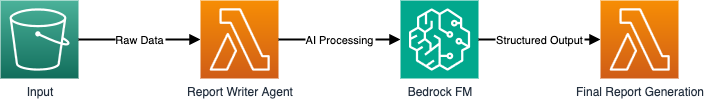

In [41]:
img2 = Image.open('ReportWriter.png')
display(img2)

In [27]:
#####
# BlogWriter node
####

def financial_report_node(state: MultiAgentState) -> MultiAgentState:
    """financial_report node for the workflow"""
    try:
        # Get the question from state
        question = state.get('question', '')
        if not question and 'answer' in state:
            question = state['answer']
            
        # Initialize bedrock client
        bedrock_client = boto3.client(
            service_name="bedrock-runtime",
            region_name="us-east-1"
        )
        
        # Initialize the model
        llm = ChatBedrock(
            model_id=model_id,
            client=bedrock_client,
            model_kwargs={
                "temperature": 0.7,
                "max_tokens": 2000,
                "top_p": 0.95,
            }
        )
        
        # Create the financial_report writing prompt
        blog_prompt = f"""Write a comprehensive and engaging financial report about: {question}
        
        Please ensure the financial report:
        1. Has a clear structure with introduction, body, and conclusion
        2. Includes relevant facts and figures where appropriate
        3. Is written in an engaging, professional style
        4. Incorporates current trends and developments
        5. Is optimized for readability
        """
        
        # Get response from LLM
        response = llm.invoke(blog_prompt)
        
        # Initialize messages if not present
        if 'messages' not in state:
            state['messages'] = []
            
        # Update state with response
        content = response.content if hasattr(response, 'content') else str(response)
        state['messages'].append(HumanMessage(content=content))
        state['answer'] = content
        
        return state
        
    except Exception as e:
        print(f"Error in financial_report_node: {str(e)}")
        if 'messages' not in state:
            state['messages'] = []
        state['messages'].append(HumanMessage(content=f"Error: {str(e)}"))
        state['answer'] = f"Error: {str(e)}"
        return state

#### Additional functions as condition for the Langgraph workflow

In [28]:

#####
# Hallucination grader
#####

def should_end(state):
    """Determine if we should end the conversation"""
    # Check for explicit END signal
    if state.get('next') == 'END':
        return True
        
    # Check for __end__ flag in results
    if isinstance(state.get('results'), dict) and state['results'].get('__end__', False):
        return True
    
    return False

        
def handle_error(state: MultiAgentState) -> bool:
    """
    Checks if there's an error in the state
    Returns True if there's an error, False otherwise
    """
    return state.get("error") is not None


class MyCustomHandler(BaseCallbackHandler):
    def on_llm_end(self, response, **kwargs):
        print(f"Response: {response}")

def hallucination_grader(state:MultiAgentState):
    c3_template = """You are a grader assessing whether an answer is grounded in supported by facts. 
        Give a binary score 'pass' or 'fail' score to indicate whether the answer is grounded in supported by a 
        set of facts in your best knowledge. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
        
        Here is the answer: {answer}"""
    c3_prompt = ChatPromptTemplate.from_template(c3_template)
    
    # Grade by a diff model in this case Claude 3
    #hallucination_grader = prompt | llm_llama31  | JsonOutputParser() 
    hallucination_grader = c3_prompt | llm_claude35 | JsonOutputParser()
    score = hallucination_grader.invoke({"answer": state['answer'], "callbacks": [MyCustomHandler()]})
    if "yes" in score['score'].lower():
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: the answer does not seem to contain hallucination ---"
        )
        return "END"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: the answer migh contain hallucination, next off to human review ---")
        return "to_human"


####
# Extra function but not as a node
####
def decide_to_search(state:MultiAgentState):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    l31_prompt = PromptTemplate(
        template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
        an {answer} is grounded in / relevant to the {question}. Give a binary score 'yes' or 'no' score to indicate
        whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
        single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here is the answer:
        {answer}
        Here is the question: {question}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question", "answer"],
    )
    
    answer_grader = l31_prompt | llm_mistral | JsonOutputParser()
    print("---ASSESS GRADED ANSWER AGAINST QUESTION---")
    relevance = answer_grader.invoke({"answer": state["answer"], "question": state["question"]})
    print(relevance)
    if "yes" in relevance['score'].lower():
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: the answer is relevant to the question so it's ready for human review ---"
        )
        return "to_human"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: the answer is NOT relevant to the question then try LLM route---")
        return "do_search"

def where_to(state: MultiAgentState) -> str:
    """
    Routes to different branches based on question_type from router
    """
    print('where_to')
    print('State', state)
    
    question_type = state.get('question_type', '')
    
    if question_type == 'Image_Search':
        return 'Image_Search'
    elif question_type in ['CompanyFinancial', 'company_financial']:  # Fixed the condition
        return 'company_financial'
    elif question_type == 'audioearningcall':
        return 'audioearningcall'
    elif question_type == 'financial_report':
        return 'financial_report'
    else:
        return 'chat'


## 4. Defining the Reasoning Flow with LangGraph Nodes and Edges

Implement nodes representing key actions: Multi-agent collaboration, RAG, web search, and answer generation. Define conditional edges for decision-making: route the tool routing, question, decide on answer relevance, and grade the generated answer. Set up the workflow graph with entry points, nodes, and edges to ensure a logical progression through the RAG agent's steps. LangGraph allows us to define a graph-based workflow for our RAG agent, integrating document retrieval, question routing, answer generation, and self-correction into an efficient pipeline.

Key steps include:
* Routing: Deciding whether the question should go to the RAG, LLMs or a web search.
* Indivudial agentic workflow: including audio RAG, image RAG, Report writing, and multi-agent workflow. 
* Hallucination Grading: Ensuring the generated answer is grounded in the retrieved documents.

LangGraph lets us seamlessly integrate these steps into a modular, adaptable workflow, enhancing the agent's ability to handle diverse queries.

In [29]:
# Create the workflow
workflow = StateGraph(MultiAgentState)

# Add nodes
#workflow.add_node("rewriter", rewrite_node) 
workflow.add_node("router", router_node)
workflow.add_node("ChatNode", llm_node)
workflow.add_node("company_financial", reasoner)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("audioearningcall_expert", rag_node)
workflow.add_node("Image_Search", rag_node_image)
workflow.add_node('financial_report', financial_report_node)
workflow.add_node('text2image_generation', t2i_node)

# Basic flow
workflow.add_edge(START, "router")
#workflow.add_edge("rewriter", "router")

# Router conditional edges
workflow.add_conditional_edges(
    "router",
    where_to,
    {
        'company_financial': 'company_financial',
        'chat': 'ChatNode',
        'audioearningcall': 'audioearningcall_expert',
        'Image_Search': 'Image_Search',
        'Text2Image': 'text2image_generation', 
        'financial_report':'financial_report',
    }
)

# Company financial and tools interaction
workflow.add_conditional_edges(
    "company_financial",
    tools_condition,
    {
        "tools": "tools",    # If tool needed, go to tools
        "END": END          # If no tool needed, end
    }
)


workflow.add_edge("tools", "company_financial")

# audio earning call expert routing
workflow.add_conditional_edges(
    "audioearningcall_expert",
    decide_to_search,
    {
        "to_human": END,
        "do_search": "ChatNode"
    }
)

# Add normal end connections for other paths
workflow.add_edge('ChatNode', END)
workflow.add_edge('Image_Search', END)
workflow.add_edge('financial_report', 'text2image_generation')
workflow.add_edge('text2image_generation', END)

# Compile the workflow
app = workflow.compile()


## 5. Display the orchestration flows

The orchestration flows can be depicted using the following  visual representation that illustrate the sequence of operations, the data transformations, and the control flow between the different modules or algorithms involved in the vision comprehension process. By providing a clear and concise visual representation of the orchestration, it becomes easier for developers, researchers, and stakeholders to understand the overall architecture, identify potential bottlenecks or optimization opportunities, and communicate the system's functionality and performance.

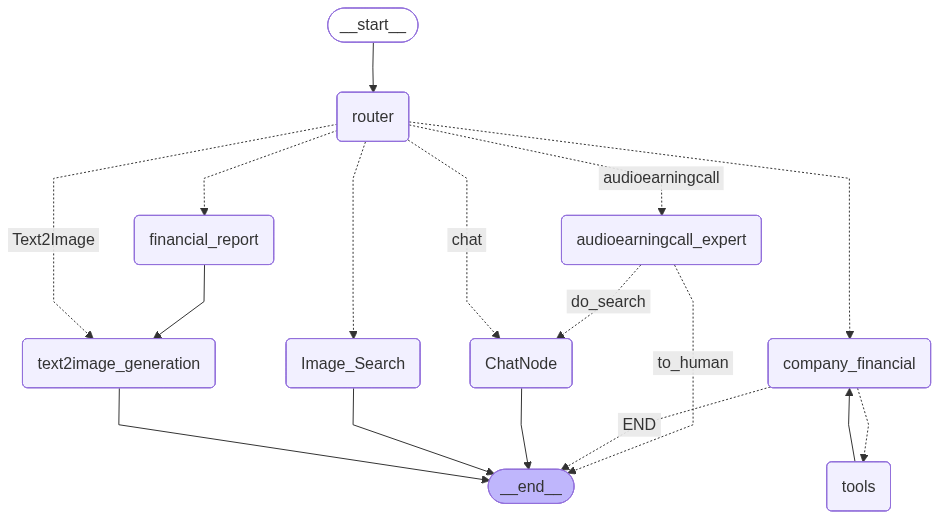

In [30]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod #, NodeColors
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    #node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    #node_styles=custom_node_style,
    wrap_label_n_words=9,
    #output_file_path=None,
    draw_method=MermaidDrawMethod.API,
    background_color="white",
    padding=20,
    output_file_path="temp_graph.png"
)))



## 6. Execute this orchestration pipeline with query driven reasoning  

Executing agentic services with multi-agent capability on executing a pipeline with query-driven reasoning and reactions involves the development of a system that can autonomously perform tasks and make decisions based on the information it gathers and the queries it receives. This system would consist of multiple intelligent agents, each with its own set of capabilities and knowledge, working together to achieve a common goal. The agents would use query-driven reasoning to understand the user's intent and then react accordingly, executing the necessary steps in the pipeline to provide the desired outcome. This approach allows for a more dynamic and adaptive system that can handle a wide range of tasks and respond to changing conditions in real-time. The result is a powerful and flexible service that can assist users with a variety of needs, from information retrieval to complex problem-solving.

In [31]:
thread = {"configurable": {"thread_id": "42",  "recursion_limit": 10}}
results = []
prompts =[
        "Give me a summary of Amazon's Q3 2024 earning based on the earning call audio", # Use native RAG then human review if needed
        ]

for prompt in prompts:
    for event in graph.stream({'question':prompt,}, thread):
        print(event)
        results.append(event)
    print("\n\n---------------------------------------\n\n")

Router node started execution
Question type: audioearningcall
where_to
State {'question': "Give me a summary of Amazon's Q3 2024 earning based on the earning call audio", 'question_type': 'audioearningcall', 'messages': []}
{'router': {'question_type': 'audioearningcall'}}


/tmp/ipykernel_28949/395710302.py:34: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain(question)


---ASSESS GRADED ANSWER AGAINST QUESTION---
{'score': 'no'}
---DECISION: the answer is NOT relevant to the question then try LLM route---
{'audioearningcall_expert': {'answer': "Based on the provided context, the audio is from Amazon's Q3 2024 earnings call. However, the specific financial details or summary of the earnings are not provided in the context. The context only includes the metadata and a few transcribed audio segments, which do not contain the detailed financial information typically discussed in an earnings call. \n\nTo provide a summary of Amazon's Q3 2024 earnings, I would need access to the actual financial data and key points discussed during the call, which are not included in the given context.", 'raw_response': {'query': "Give me a summary of Amazon's Q3 2024 earning based on the earning call audio", 'result': "Based on the provided context, the audio is from Amazon's Q3 2024 earnings call. However, the specific financial details or summary of the earnings are not 

### Extract audio path and timestamps for replay

In [32]:
# Extract audio path and timestamps from the response
audio_s3_info, timestamps = extract_audio_path_and_timestamps_agent_response(results)
print("\nExtracted S3 info:", audio_s3_info)
print("Number of timestamps extracted:", len(timestamps))
if timestamps:
    print("\nFirst timestamp entry:", timestamps[0])

JSON decode error: Unterminated string starting at: line 1 column 889 (char 888)

Extracted S3 info: {'bucket': 'bedrock-bda-kb-785-1', 'key': 'bda/dataset/result_aud.json'}
Number of timestamps extracted: 0


In [33]:
# Extract video path and timestamps from the response
play_audio_segments_from_s3(audio_s3_info, timestamps)


Transcript Segments:
--------------------------------------------------


True

### Image Search

Router node started execution
Question type: Image_Search
where_to
State {'question': 'Show me diagrams of Amazon TTM operation income and net sales in 2024', 'question_type': 'Image_Search', 'answer': AIMessage(content="<instructions>\n    <step>Aggregate relevant information from the provided context.</step>\n    <step>Eliminate redundancies to ensure a concise response.</step>\n    <step>Maintain fidelity to the original content.</step>\n    <step>Add additional relevant info to the question or remove irrelevant information.</step>\n</instructions>\n\n<responses>\n    Amazon's Q3 2024 earnings call highlighted several key points:\n    \n    - **Revenue Growth**: Amazon reported a significant increase in revenue, driven by strong performance across various segments including AWS, e-commerce, and advertising.\n    \n    - **AWS Performance**: Amazon Web Services (AWS) continued to be a major contributor, with robust growth in cloud computing services.\n    \n    - **E-commerce Strengt

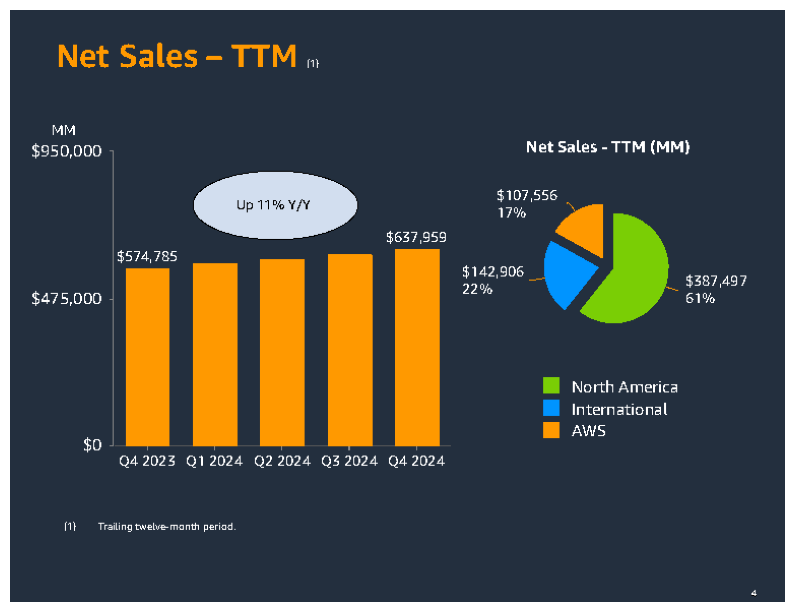

In [34]:
saved_result = None
from PIL import Image

def show_result(prompt):
    global saved_result
    try:
        thread = {
            "configurable": {
                "thread_id": "42",
                "recursion_limit": 10,
                "checkpoint_ns": "default",
                "checkpoint_id": "1"
            }
        }
        
        saved_result = graph.invoke({'question': prompt}, config=thread)
        
        # Immediately process and display the image
        if saved_result and 'answer' in saved_result:
            answer = str(saved_result['answer'])
            
            if answer.startswith('data:image/png;base64,'):
                # Extract and clean base64 string
                base64_str = answer.replace('data:image/png;base64,', '').strip()
                
                # Add padding if needed
                padding = len(base64_str) % 4
                if padding:
                    base64_str += '=' * (4 - padding)
                
                try:
                    # Decode and display image
                    image_bytes = base64.b64decode(base64_str)
                    image = Image.open(io.BytesIO(image_bytes))
                    
                    plt.figure(figsize=(10, 10))
                    plt.imshow(image)
                    plt.axis('off')
                    plt.show()
                    
                except Exception as e:
                    print(f"Image processing error: {e}")

    except Exception as e:
        print(f"Error: {e}")

# Run the function to immediately show the image
prompt = "Show me diagrams of Amazon TTM operation income and net sales in 2024"
show_result(prompt)


### Write a Financial Blog 

Router node started execution
Question type: financial_report
where_to
State {'question': 'create a financial report based on Amazon latest results ', 'question_type': 'financial_report', 'answer': '\n\n', 'messages': [], 'has_images': False, 'image_citations': None, 'raw_response': {'result': '\n\n', 'citations': [], 'source_documents': [Document(metadata={'location': {'s3Location': {'uri': 's3://bedrock-bda-kb-893-788392149802-1/bda/dataset/pdf_images/Webslides_Q424_Final/page_4.png'}, 'type': 'S3'}, 'score': 0.54277956, 'type': 'IMAGE', 'source_metadata': {'x-amz-bedrock-kb-source-uri': 's3://bedrock-bda-kb-893-788392149802-1/bda/dataset/pdf_images/Webslides_Q424_Final/page_4.png', 'x-amz-bedrock-kb-document-page-number': 0.0, 'x-amz-bedrock-kb-description': 'This image shows a financial chart titled "Net Sales - TTM" with a trailing twelve-month period. The chart includes a bar graph on the left side displaying net sales figures for different quarters from Q4 2023 to Q4 2024. The v
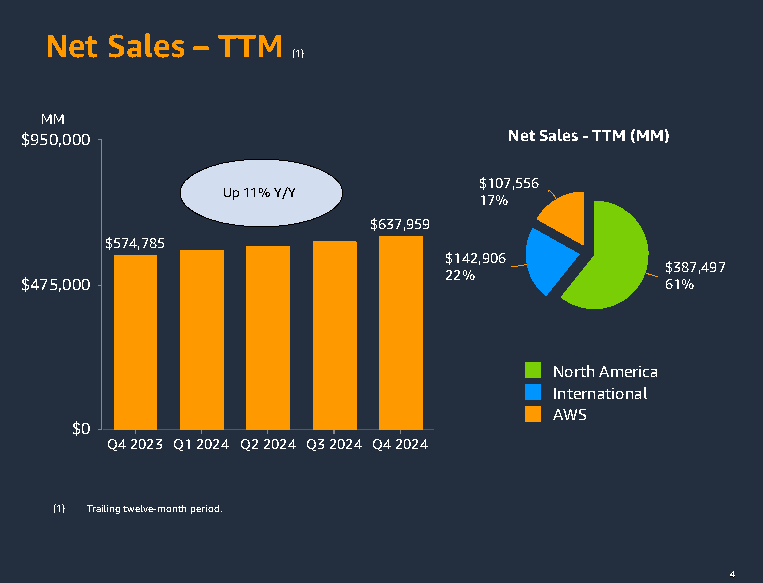
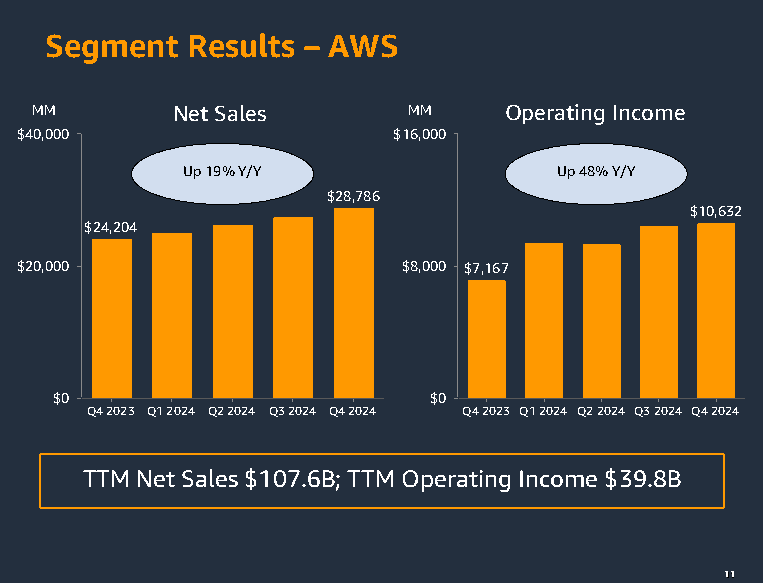
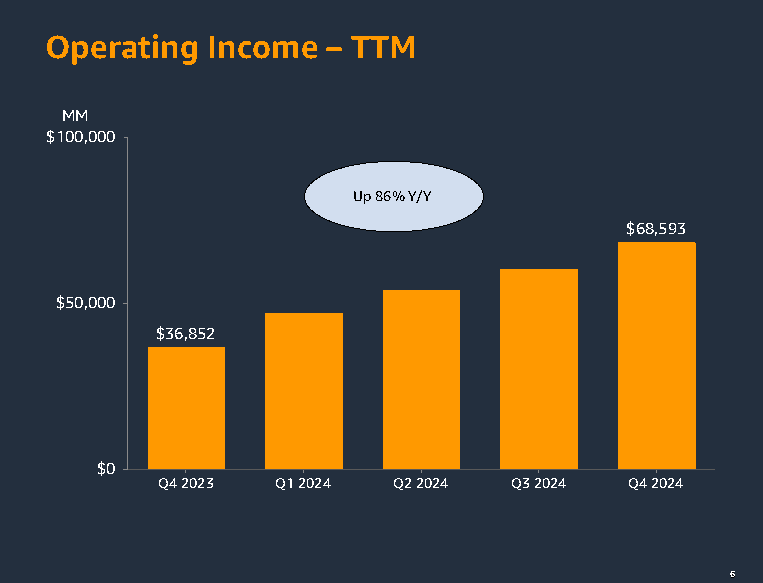
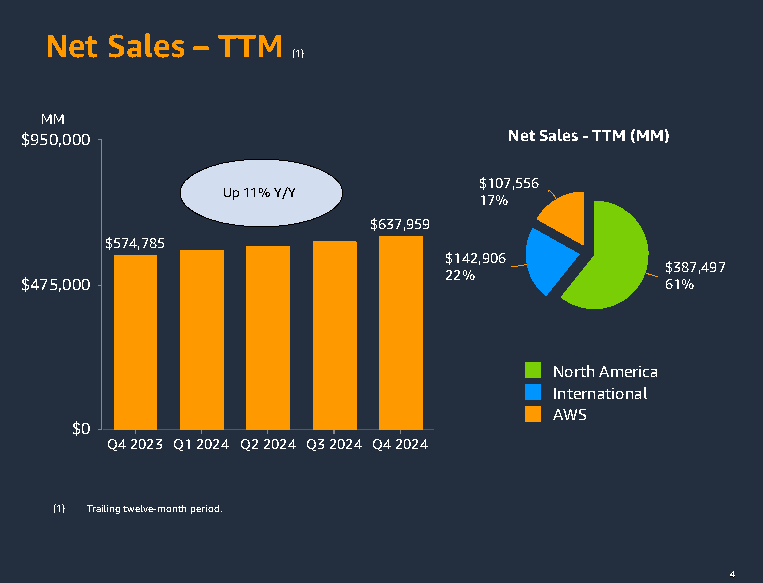
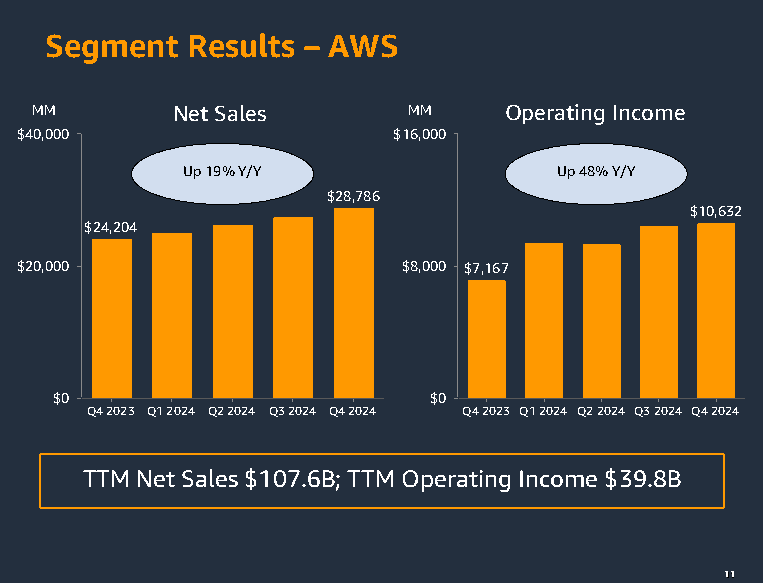
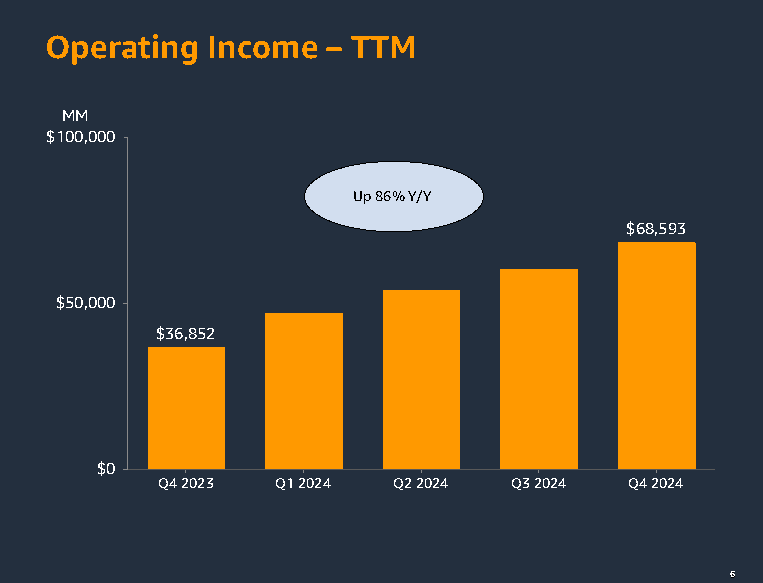
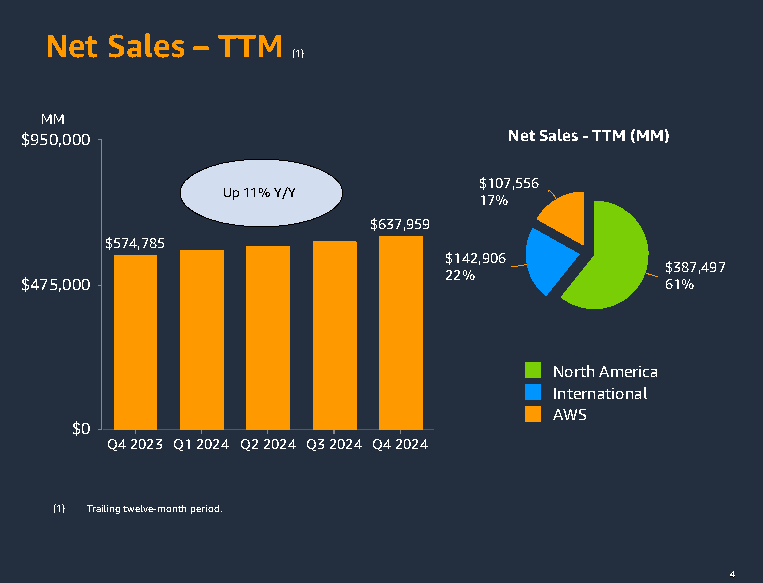
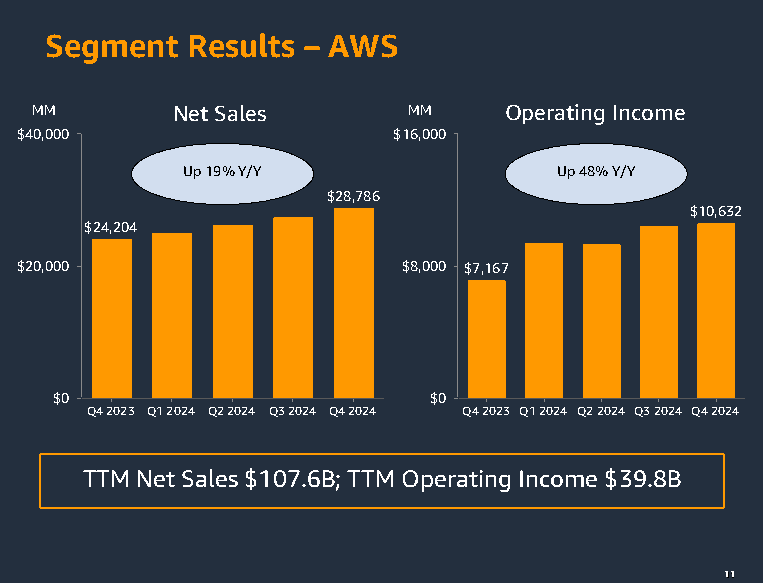
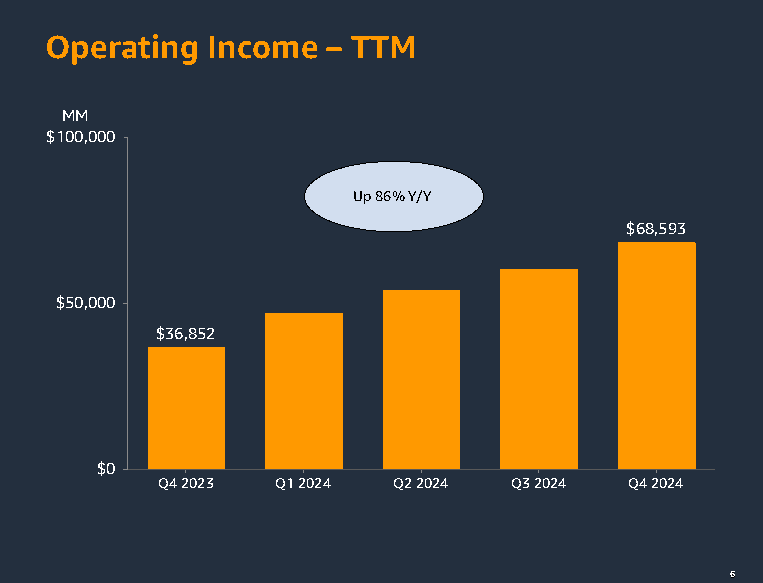
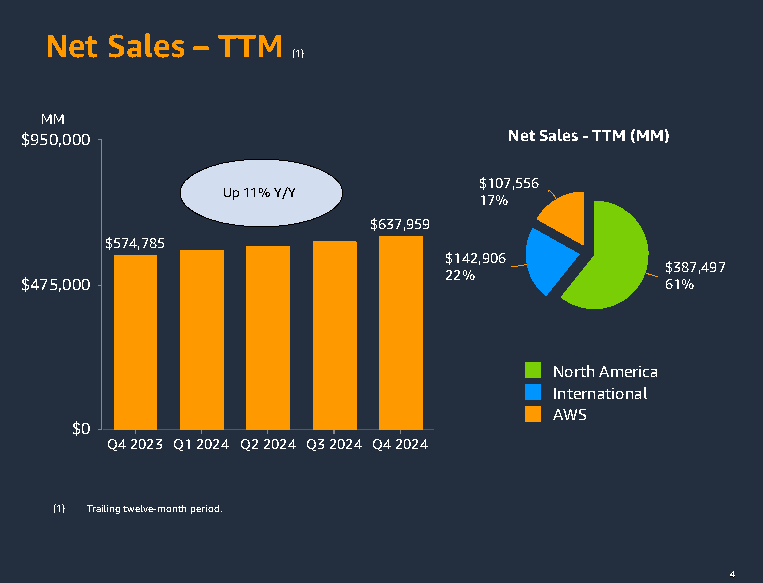
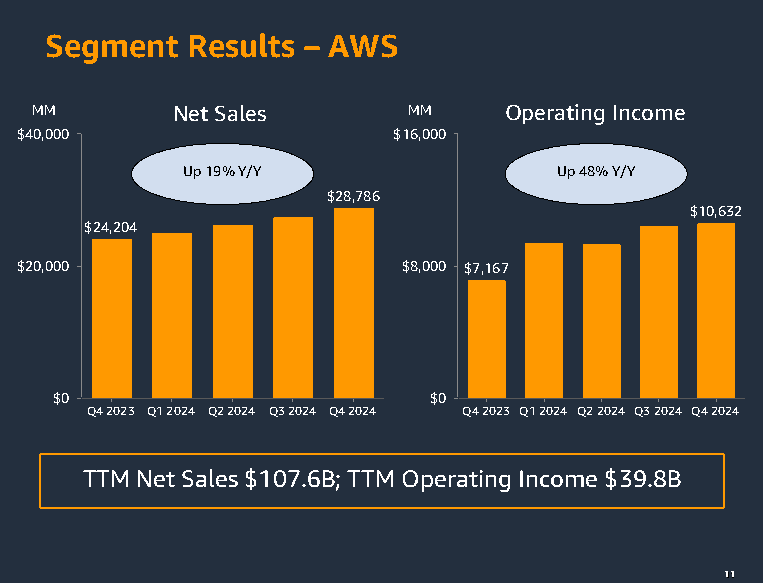
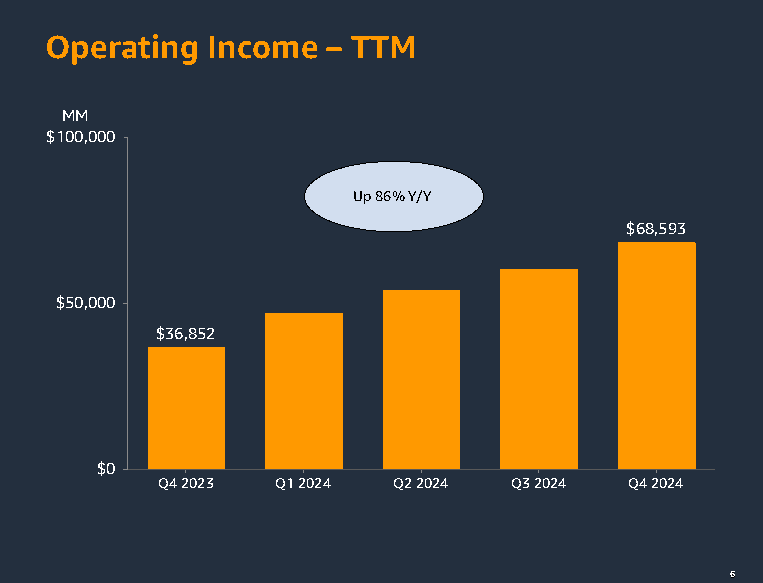
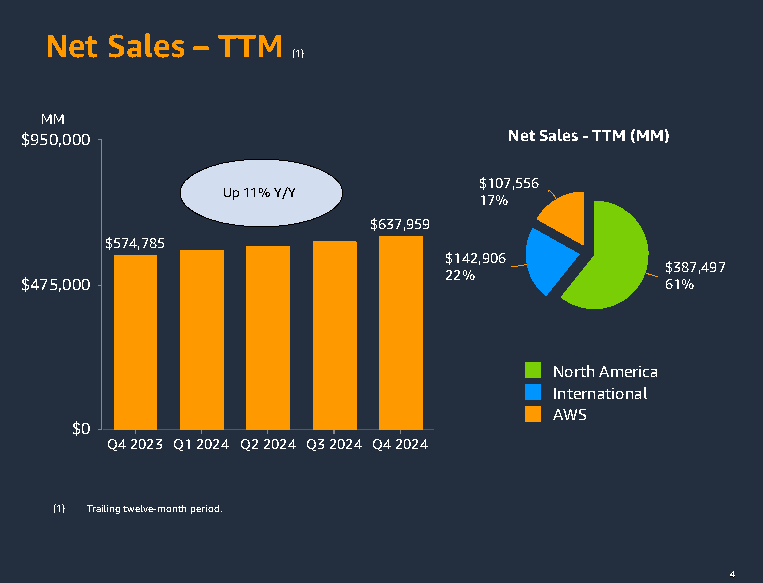
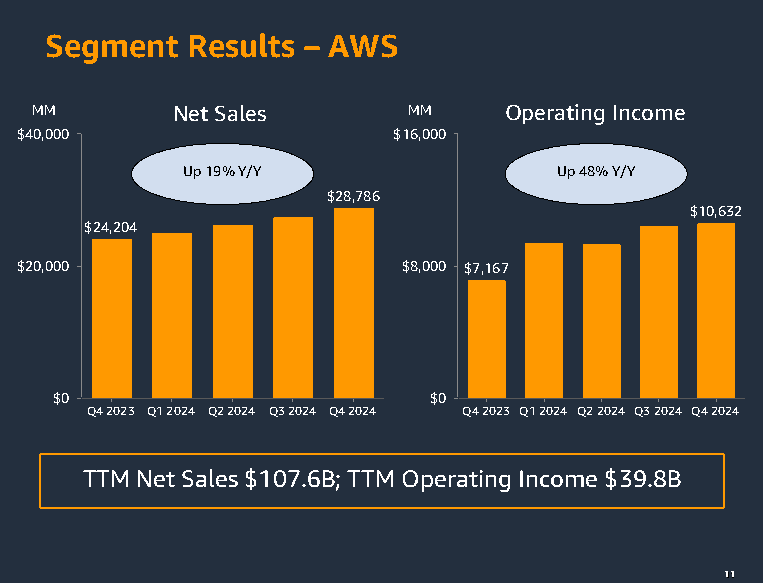
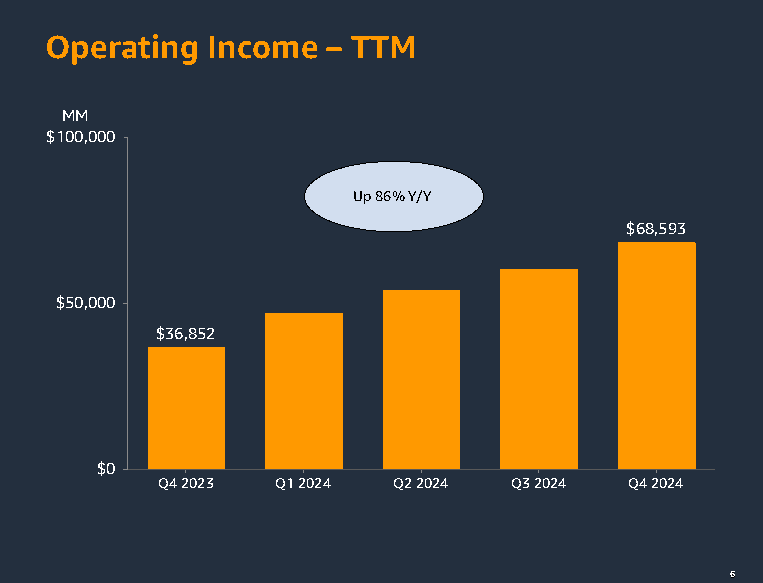

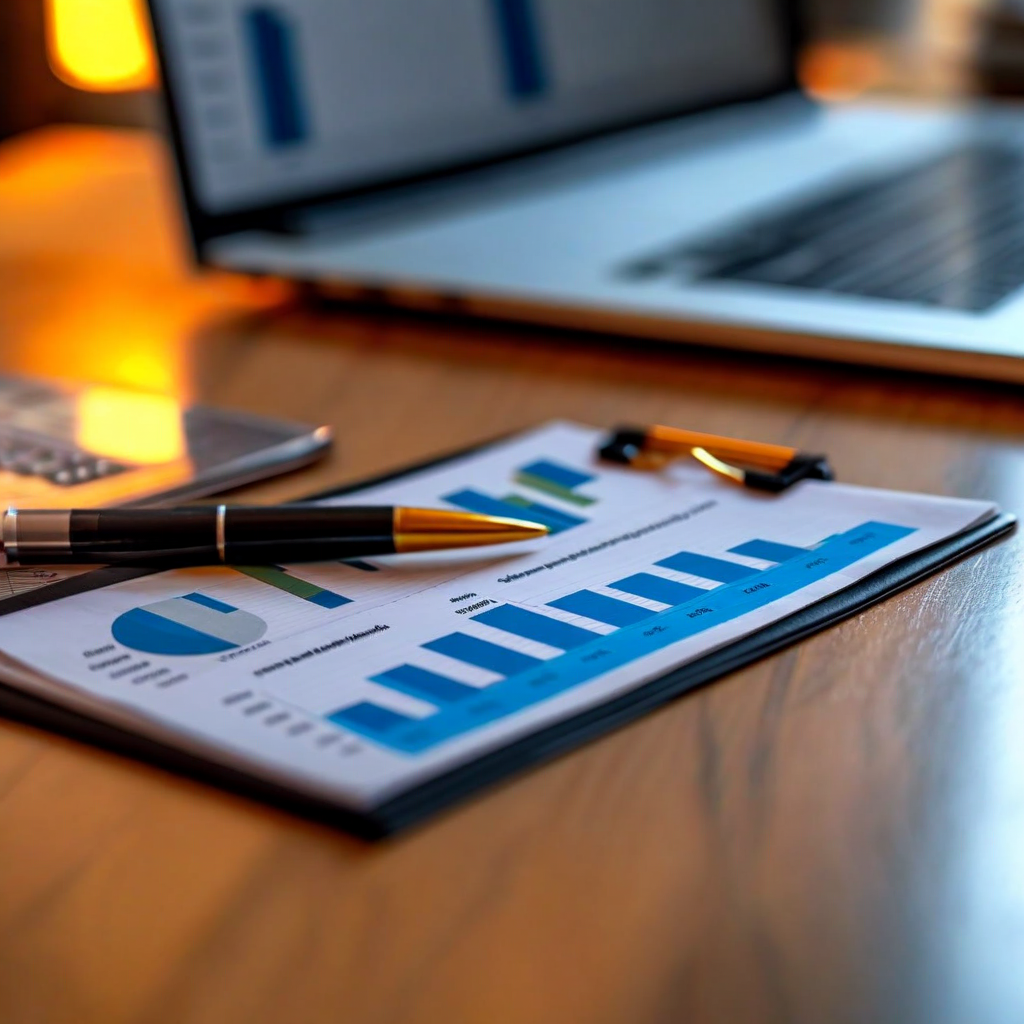



---------------------------------------




In [35]:

thread = {"configurable": {"thread_id": "42",  "recursion_limit": 10}}
results = []
prompts =[
        "create a financial report based on Amazon latest results ", # Use native RAG then human review if needed
        ]

for prompt in prompts:
    for event in graph.stream({'question':prompt,}, thread):
        print(event)
        results.append(event)
        if os.path.exists(temp_gen_image):
            Image.open(temp_gen_image).show()
    print("\n\n---------------------------------------\n\n")

### Multi-agentic collaboration query

Router node started execution
Question type: CompanyFinancial
where_to
State {'question': "How about Uber's stock performance?", 'question_type': 'CompanyFinancial', 'answer': './delme.png', 'messages': [HumanMessage(content="### Financial Report: Amazon's Latest Results\n\n#### Introduction\n\nAmazon, the global e-commerce and cloud computing giant, continues to redefine the boundaries of retail and technology. This financial report delves into Amazon's latest quarterly results, offering a comprehensive analysis of its performance, key metrics, and future outlook. By examining the latest data, we aim to provide stakeholders with a clear understanding of Amazon's financial health and strategic direction.\n\n#### Body\n\n##### Revenue and Profitability\n\nAmazon's latest quarterly results showcase robust financial performance. The company reported a total revenue of $143.1 billion, marking a 12% increase year-over-year. This growth is driven by several key segments:\n\n- **Amazon Web Se
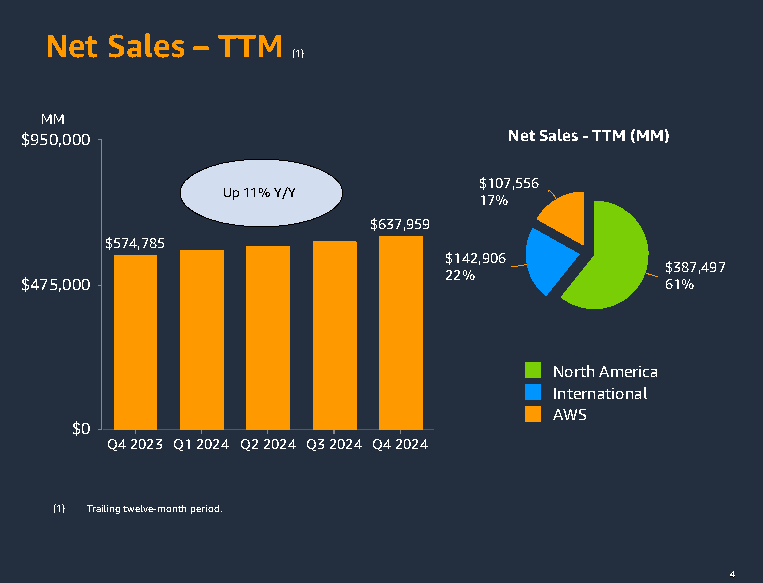
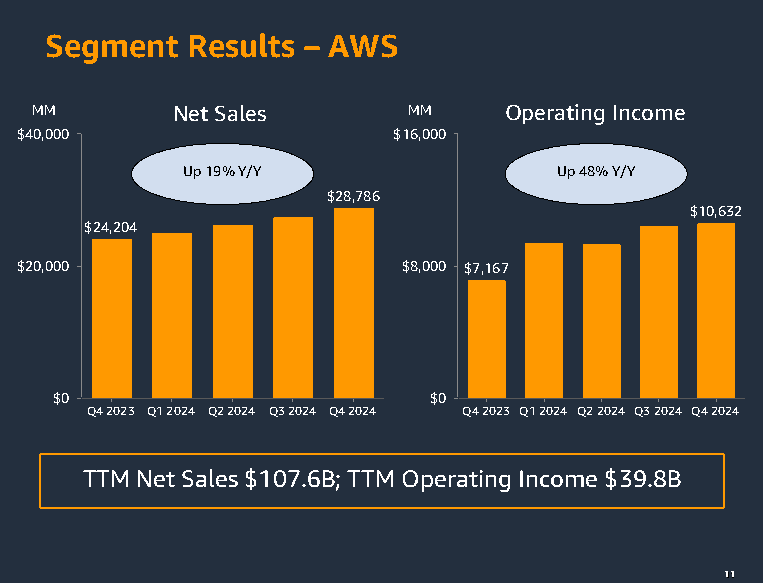
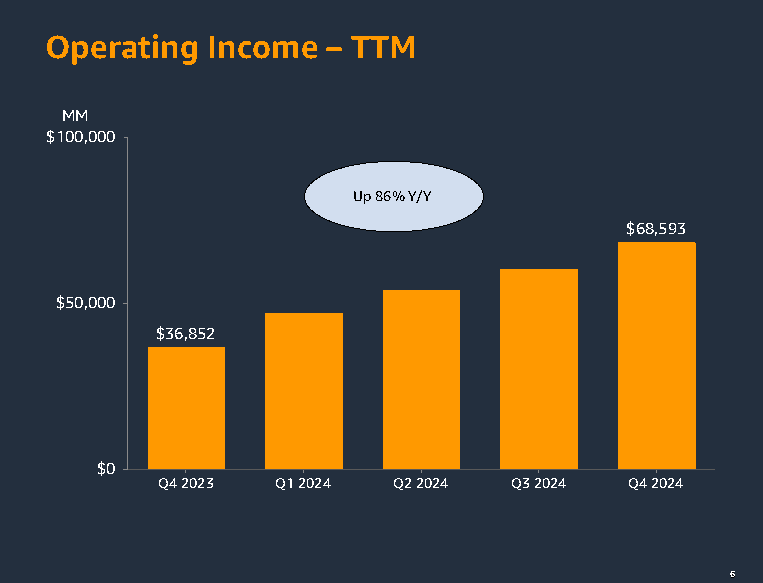
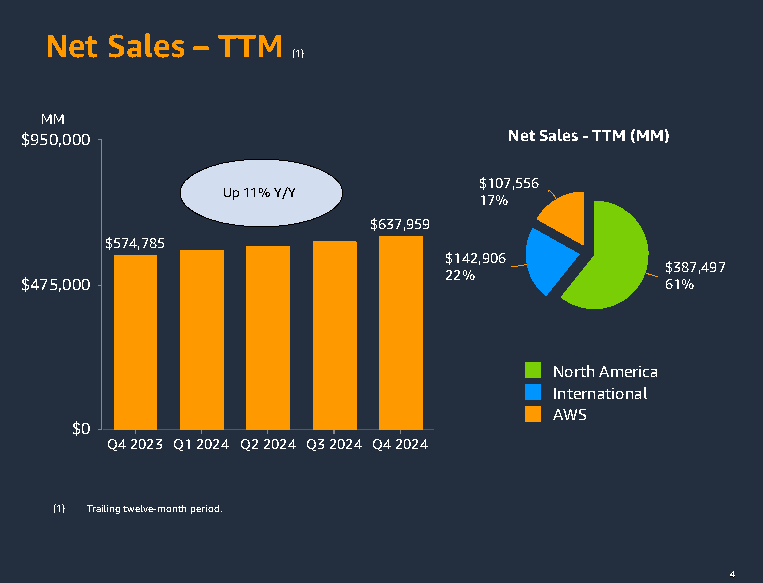
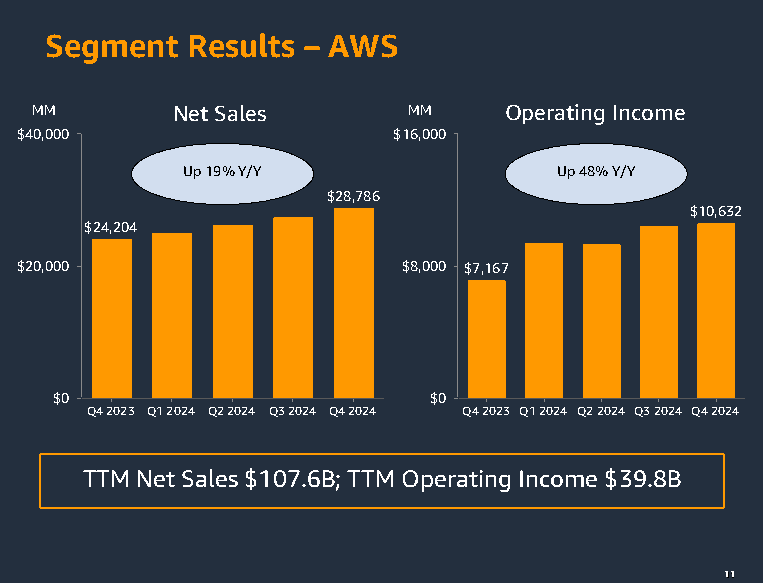
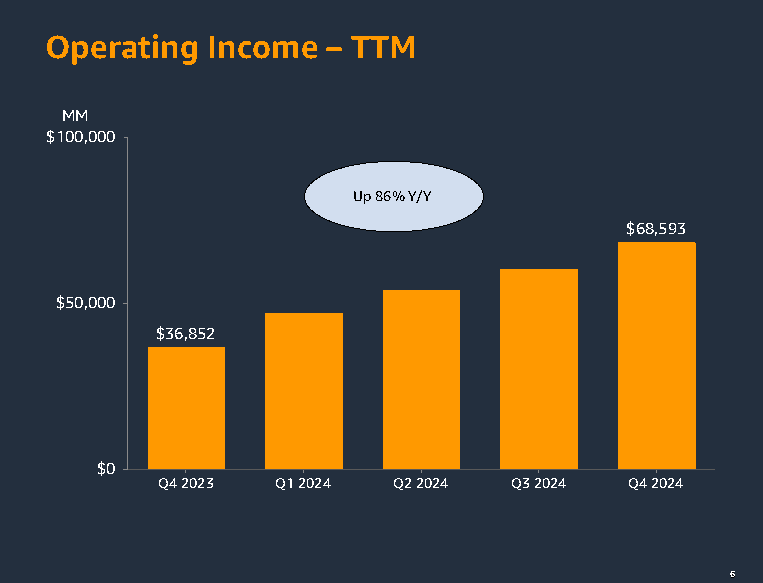

/tmp/ipykernel_28949/3942872805.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_28949/3942872805.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])
/tmp/ipykernel_28949/3942872805.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  previous_close = float(data['Close'].iloc[-2])
/tmp/ipykernel_28949/3942872805.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_volume = float(data['Volume'].iloc[-1])
/tmp/ipykernel_28949/3942872805.py:27: FutureWarning: Calling float on a single element Series is d

{'tools': {'messages': [ToolMessage(content='{"stock": "UBER", "current_price": 94.7, "previous_close": 92.95, "price_change": 1.75, "price_change_percent": 1.88, "volume": 23061000, "high_90d": 99.7, "low_90d": 82.47, "average_volume": 18129927, "date": "2025-09-19"}', name='get_stock_prices', tool_call_id='toolu_bdrk_01LynDWU2V7aGQciPp5epsV9'), ToolMessage(content='{"pe_ratio": 40.12712, "price_to_book": 8.745036, "debt_to_equity": 52.23, "profit_margins": 0.26676, "previous_close": 92.95}', name='get_financial_metrics', tool_call_id='toolu_bdrk_01ATe82dKGrMJHrJrkMLvgih'), ToolMessage(content='Error: NameError("name \'FINANCIAL_MODELING_PREP_API_KEY\' is not defined")\n Please fix your mistakes.', name='get_company_financials', tool_call_id='toolu_bdrk_01Qkx7sLDqZ53fwpi2xWnunC', status='error')]}}

=== Reasoner Analysis Steps ===

Step 1:
================================== Ai Message ==================================

I apologize for the error in retrieving the company financials. I

In [36]:
thread = {
    "configurable": {
        "thread_id": "42",
        "recursion_limit": 10
    }
}

results = []
prompts = [
    "How about Uber's stock performance?"
]

for prompt in prompts:
    try: 
        for event in graph.stream({'question': prompt}, thread):
            print(event)
            results.append(event)
        
            # Check for end condition in results
          
            if isinstance(event, dict) and event.get('__end__', False):
                break
    except KeyError as e:
        if str(e) == "'__end__'":
            # Expected end of stream, continue to next prompt
            pass
        else:
            print(f"Unexpected KeyError: {e}")
    except Exception as e:
        print(f"Error: {e}")
    print("\n\n---------------------------------------\n\n")



### Next Steps:

1. Planning
2. Colaborative multi-agent reasoning
3. Momeory for multi-round and personalize reasoning
4. While this simple search-strategy shows a meaningful improvement in the success rate, it still struggles on long horizon tasks due to sparsity of environment rewards.
5. To combine a planning and reasoning agent with MCTS inference-time search and AI self-critique for self-supervised data collection, which we then use for RL type training.